In [1]:
import numpy as np
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
data = pd.read_csv("/content/judge-1377884607_tweet_product_company.csv",encoding='ISO-8859_1')

In [4]:
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [6]:
data.shape

(9093, 3)

In [7]:
data.rename(columns={'emotion_in_tweet_is_directed_at':'emotion_towards','is_there_an_emotion_directed_at_a_brand_or_product':'emotion_reaction'},inplace=True)

In [8]:
data.head()

,tweet_text,emotion_towards,emotion_reaction
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [9]:
data.drop(['emotion_towards'],axis=1)

,tweet_text,emotion_reaction
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion
...,...,...
9088,Ipad everywhere. #SXSW {link},Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,No emotion toward brand or product


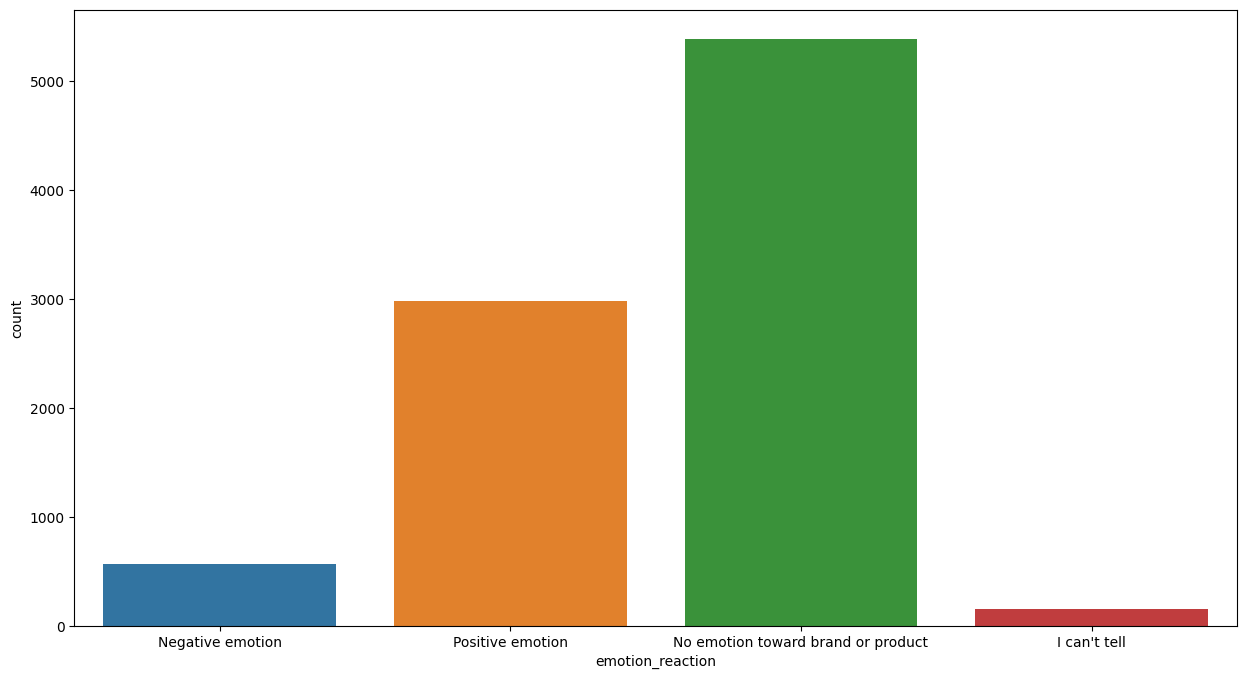

In [10]:
plt.figure(figsize=(15,8))
sns.countplot(x='emotion_reaction',data=data)
plt.show()

In [11]:
# Convert the data types to string
data['tweet_text'] = data['tweet_text'].astype(str)

In [12]:
label_encoder = {'Negative emotion': 'negative',
                 'Positive emotion': 'positive',
                 'No emotion toward brand or product': 'neutral',
                 "I can't tell":'no_idea'}

In [13]:
data = data[['emotion_reaction', 'tweet_text']]
data.head()

,emotion_reaction,tweet_text
0,Negative emotion,.@wesley83 I have a 3G iPhone. After 3 hrs twe...
1,Positive emotion,@jessedee Know about @fludapp ? Awesome iPad/i...
2,Positive emotion,@swonderlin Can not wait for #iPad 2 also. The...
3,Negative emotion,@sxsw I hope this year's festival isn't as cra...
4,Positive emotion,@sxtxstate great stuff on Fri #SXSW: Marissa M...


In [14]:
data.tweet_text.head(10)

0    .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1    @jessedee Know about @fludapp ? Awesome iPad/i...
2    @swonderlin Can not wait for #iPad 2 also. The...
3    @sxsw I hope this year's festival isn't as cra...
4    @sxtxstate great stuff on Fri #SXSW: Marissa M...
5    @teachntech00 New iPad Apps For #SpeechTherapy...
6                                                  nan
7    #SXSW is just starting, #CTIA is around the co...
8    Beautifully smart and simple idea RT @madebyma...
9    Counting down the days to #sxsw plus strong Ca...
Name: tweet_text, dtype: object

In [15]:
import string
def remove_punc(tweet_text):
  punc_free = ''.join([i for i in tweet_text if i not in string.punctuation])
  return punc_free

In [16]:
data['tweet_text'] = data['tweet_text'].apply(remove_punc)

In [17]:
def tweet_cleaner(tweet_text):
    '''
    Function to remove punctuations, special characters, html links, twitter handels etc...
    '''

    stopwords = ['rt','rts', 'retweet', 'quot', 'sxsw']

    punctuation = set(string.punctuation) # punctuation of English language
    punctuation.remove('#') # remove # so hashtags remain in x

    x = tweet_text
    x = re.sub(r'https?:\/\/\S+', '', x) # remove URL references
    x = re.sub(r'{link}', '', x)  # remove placeholders
    x = re.sub(r'@[\w]*', '', x) # remove @mention users
    x = re.sub('[^A-Za-z0-9]+', ' ', x) # remove @mention users
    x = re.sub(r'\b[0-9]+\b', '', x) # remove stand-alone numbers
    x = re.sub(r'&[a-z]+;', '', x) # remove HTML reference characters
    x = ''.join(ch for ch in x if ch not in punctuation) # remove punctuation
    x = x.replace("[^a-zA-z#]", " ")  #remove special characters

    x = [word.lower() for word in x.split() if word.lower() not in stopwords]
    x = [w for w in x if len(w)>2]

    return ' '.join(x)

In [18]:
# Apply the tweet cleaner to whole dataframe
data['tweet_text'] = data['tweet_text'].apply(tweet_cleaner)

In [19]:
def tokenization(tweet_text):
  words = nltk.word_tokenize(tweet_text)
  return words

In [20]:
data['tweet_text'] = data['tweet_text'].apply(tokenization)

In [21]:
stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(tweet_text):
  output = [i for i in tweet_text if i not in stopwords]
  return output

In [22]:
data['tweet_text'] = data['tweet_text'].apply(remove_stopwords)

In [23]:
from nltk.stem import WordNetLemmatizer
wordnet_lem = WordNetLemmatizer()
def lemm(tweet_text):
  lemm_text = [wordnet_lem.lemmatize(word) for word in tweet_text]
  return lemm_text

In [24]:
data['tweet_text'] = data['tweet_text'].apply(lemm)

In [25]:
X = data[['tweet_text']]
y = data['emotion_reaction']

In [34]:
# Vectorizing
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(X_train['tweet_text'].str[0]).toarray()
X_test = tfidf_vectorizer.transform(X_test['tweet_text'].str[0]).toarray()



In [59]:
X = data['tweet_text']
y= pd.get_dummies(data['emotion_reaction'])

In [60]:
y=np.asarray(y).astype(np.float32)

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y,
                                                    random_state=42)

In [62]:
def create_tokens(X_train,X_test):
    '''
    A simple function to create word tokens with padded sequences
    '''
    tokenizer = Tokenizer(oov_token=True)
    tokenizer.fit_on_texts(X_train)

    X_train= tokenizer.texts_to_sequences(X_train)
    X_test= tokenizer.texts_to_sequences(X_test)


    maxlen = len(max(X_train, key=lambda x: len(x)))
    maxlen_orig= len(max(X_train, key=lambda x: len(x)))

    X_train= pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test= pad_sequences(X_test, padding='post', maxlen=maxlen)


    return X_train, X_test,maxlen,tokenizer

In [63]:
model=Sequential()
model.add(Embedding(input_dim = 20000,output_dim = 100))
model.add(LSTM(128, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)            │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ lstm_4 (LSTM)                      │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_4 (Dense)                    │ ?                             │ 0 (unbuilt) │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [64]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [66]:
model.fit(X_train, y_train, batch_size=256, epochs=4)

ValueError: ignored